<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/education_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教育スコア
- input
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
        - 幼稚園スコア
        - 学習塾スコア
    - library_score.csv
        - 図書館スコア
        - 書店スコア
- output
    - education_score.csv
        - 教育スコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '教育スコア'
output_score_file = 'education_score.csv'

### 地理マスタ

In [6]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']].set_index('town_id')
print(df_geo_master.shape)

(3145, 5)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    'town_id', '小学校スコア', '中学校スコア', '幼稚園スコア', '学習塾スコア'
]].set_index('town_id')
print(df_school_score.shape)

(3145, 4)


In [8]:
df_school_score.head()

,小学校スコア,中学校スコア,幼稚園スコア,学習塾スコア
town_id,,,,
101003,4.00,2.10,2.60,1.85
101004,3.32,2.10,1.89,1.14
101005,1.41,2.13,1.88,1.47
101007,3.50,2.33,1.37,0.45
101008,4.41,2.12,2.18,0.64


### 図書館・書店

In [9]:
df_library_score = pd.read_csv(os.path.join(DIR_NAME, 'library_score.csv'))[[
    'town_id', '図書館スコア', '書店スコア'
]].set_index('town_id')
print(df_library_score.shape)

(3145, 2)


In [10]:
df_library_score.head()

,図書館スコア,書店スコア
town_id,,
101003,0.23,4.74
101004,0.36,3.90
101005,0.94,4.65
101007,1.85,4.87
101008,1.54,4.36


In [11]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

### 教育スコア

In [12]:
df_score = pd.concat([
    df_geo_master,
    df_school_score,
    df_library_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_geo_master)
df_geo_master = df_score

(3145, 11)


In [13]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 11)


,市区町村名,町名,町丁目,緯度,経度,小学校スコア,中学校スコア,幼稚園スコア,学習塾スコア,図書館スコア,書店スコア
town_id,,,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,4.00,2.10,2.60,1.85,0.23,4.74
101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,3.32,2.10,1.89,1.14,0.36,3.90
101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,1.41,2.13,1.88,1.47,0.94,4.65
101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,3.50,2.33,1.37,0.45,1.85,4.87
101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,4.41,2.12,2.18,0.64,1.54,4.36


In [14]:
feature_list = {
    '小学校スコア': {'sort': 1, 'weight': 1},
    '中学校スコア': {'sort': 1, 'weight': 1},
    '幼稚園スコア': {'sort': 1, 'weight': 0.7},
    '学習塾スコア': {'sort': 1, 'weight': 0.3},
    '図書館スコア': {'sort': 1, 'weight': 0.5},
    '書店スコア': {'sort': 1, 'weight': 0.5},
}

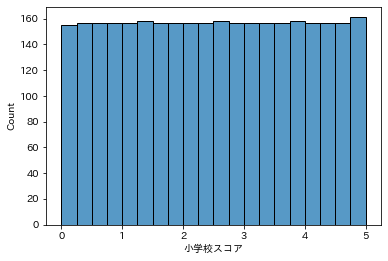

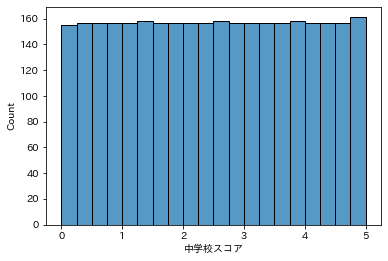

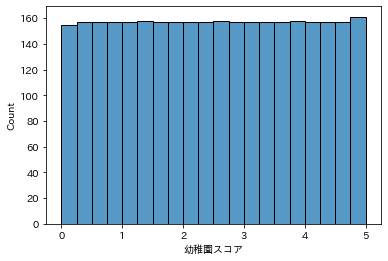

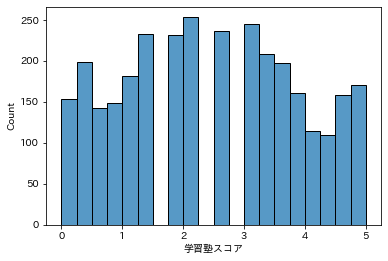

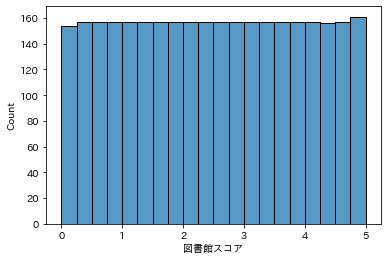

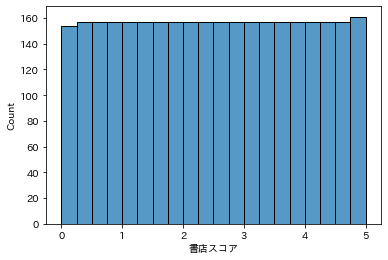

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

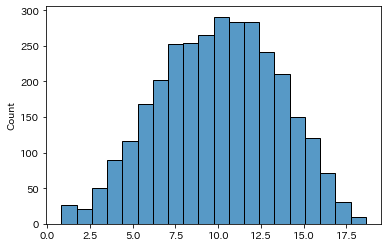

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

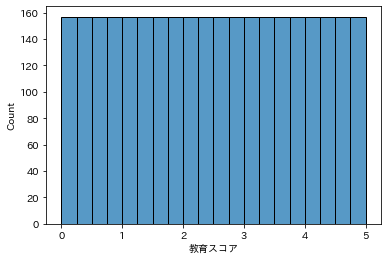

In [18]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [19]:
df_geo_master[score_name].describe()

count    3140.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 教育スコア, dtype: float64

In [20]:
df_geo_master[score_name] = df_geo_master[score_name].round(2)

In [27]:
df_geo_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True, encoding='utf-8_sig')

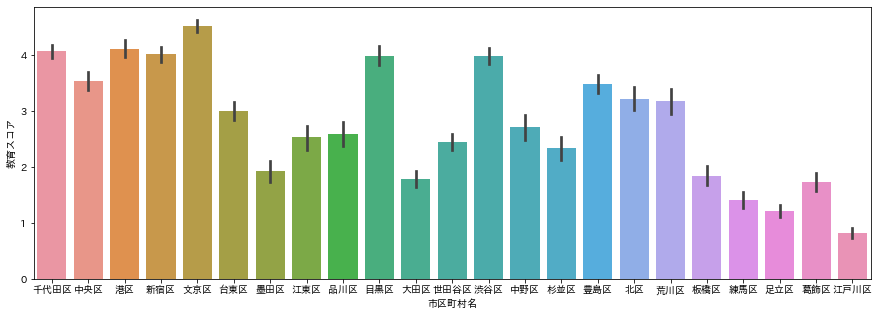

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_geo_master)
plt.show()

In [23]:
df_level = df_geo_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(901, 10)


In [24]:
df_level.head(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,幼稚園スコア,学習塾スコア,図書館スコア,書店スコア,教育スコア
0,文京区,本駒込,本駒込５丁目,4.87,4.97,4.88,1.47,4.93,3.99,5.00
1,新宿区,早稲田南町,早稲田南町,4.59,4.92,4.52,4.39,4.53,4.43,5.00
2,豊島区,西池袋,西池袋４丁目,4.68,4.62,4.47,4.39,3.94,4.63,4.99
3,新宿区,喜久井町,喜久井町,4.54,4.92,4.44,3.99,4.06,4.15,4.99
4,港区,西新橋,西新橋３丁目,4.90,4.99,4.45,1.14,4.37,4.72,4.99
5,新宿区,早稲田町,早稲田町,4.26,4.89,4.43,3.70,4.75,4.57,4.99
6,文京区,白山,白山３丁目,4.98,4.99,4.80,1.14,4.02,3.85,4.98
7,新宿区,西早稲田,西早稲田２丁目,4.77,4.56,4.54,3.38,3.12,4.95,4.98
8,文京区,小日向,小日向１丁目,4.64,4.95,4.85,1.47,4.73,3.57,4.98
9,千代田区,四番町,四番町,4.94,4.73,4.75,3.38,3.50,3.71,4.98


In [25]:
df_level.tail(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,幼稚園スコア,学習塾スコア,図書館スコア,書店スコア,教育スコア
891,足立区,西伊興町,西伊興町,1.18,0.15,0.51,1.14,1.49,1.72,0.18
892,練馬区,西大泉町,西大泉町,0.11,0.45,3.90,0.05,0.05,0.51,0.18
893,江戸川区,東篠崎町,東篠崎町,1.05,0.08,2.32,0.64,0.34,0.64,0.15
894,江戸川区,堀江町,堀江町,1.23,1.17,0.34,0.05,0.47,0.55,0.11
895,葛飾区,水元公園,水元公園,0.13,0.07,2.97,0.29,0.85,0.07,0.09
896,世田谷区,砧公園,砧公園,0.42,0.73,0.87,0.45,0.62,1.23,0.09
897,江戸川区,松本,松本２丁目,0.22,0.92,1.10,1.14,0.64,0.44,0.08
898,大田区,昭和島,昭和島１丁目,0.60,0.58,0.78,0.10,1.03,0.21,0.06
899,大田区,京浜島,京浜島１丁目,0.05,0.79,0.67,0.00,0.05,0.03,0.03
900,江戸川区,興宮町,興宮町,0.04,0.37,0.09,0.64,0.20,0.82,0.01
